In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
df = pd.read_csv('./marketing_campaign.csv')

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
# Data Preprocessing
# 1. Handle missing values in 'Income'
df['Income'].fillna(df['Income'].mean(), inplace=True)

# 2. Convert categorical columns to numerical (one-hot encoding for 'Education' and 'Marital_Status')
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)

# 3. Drop columns not needed for clustering
df.drop(['ID', 'Dt_Customer'], axis=1, inplace=True)

# 4. Scale the data
scaler = StandardScaler()
data = scaler.fit_transform(df)

In [7]:
class KMeansCustom:
    def __init__(self, k, max_iters=100, tolerance=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tolerance = tolerance

    def fit(self, data):
        # Randomly initialize centroids
        np.random.seed(42)
        self.centroids = data[np.random.choice(range(data.shape[0]), self.k, replace=False)]
        
        for i in range(self.max_iters):
            # Step 1: Assign clusters
            self.labels = self._assign_clusters(data)
            
            # Step 2: Update centroids
            new_centroids = np.array([data[self.labels == j].mean(axis=0) for j in range(self.k)])
            
            # Check for convergence
            if np.linalg.norm(new_centroids - self.centroids) < self.tolerance:
                break
            
            self.centroids = new_centroids

    def _assign_clusters(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)
    
    def predict(self, data):
        return self._assign_clusters(data)
    
    def inertia(self, data):
        return np.sum([np.sum((data[self.labels == i] - centroid) ** 2) for i, centroid in enumerate(self.centroids)])


In [40]:
from sklearn.metrics import silhouette_score

def evaluate_clusters(data, ks=[2, 5, 7, 9]):
    inertias = []
    silhouette_scores = []
    
    for k in ks:
        kmeans = KMeansCustom(k)
        kmeans.fit(data)
        inertia = kmeans.inertia(data)
        inertias.append(inertia)
        
        # Silhouette Score
        labels = kmeans.predict(data)
        sil_score = silhouette_score(data, labels)
        silhouette_scores.append(sil_score)
    
    return inertias, silhouette_scores

In [52]:
# Running the evaluation for k = 2, 5, 7, and 9
ks = [2, 5, 7, 9, 11]
inertias, silhouette_scores = evaluate_clusters(data, ks)

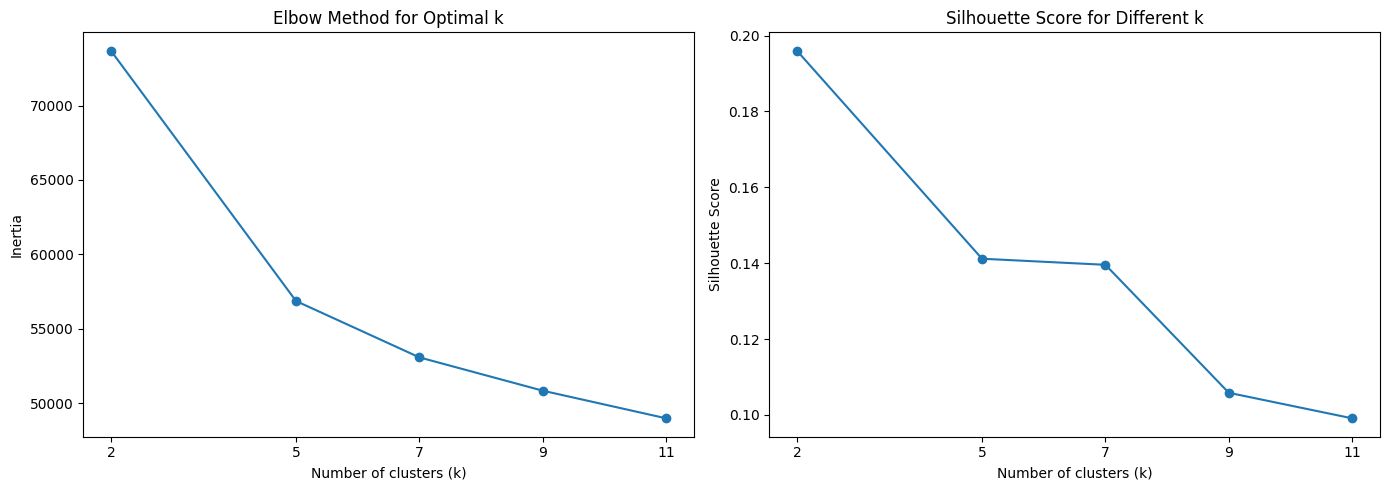

In [53]:
# Plotting the Elbow Curve and Silhouette Scores
plt.figure(figsize=(14, 5))

# Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(ks, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(ks)

# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(ks, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(ks)

plt.tight_layout()
plt.show()

In [48]:
from sklearn.decomposition import PCA

def visualize_clusters(data, labels, centroids=None):
    # Reduce data to 2 dimensions using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Plot the clusters
    plt.figure(figsize=(7, 5))
    for cluster in np.unique(labels):
        plt.scatter(
            reduced_data[labels == cluster, 0],
            reduced_data[labels == cluster, 1],
            label=f'Cluster {cluster + 1}'
        )
    
    # Plot centroids (if provided)
    if centroids is not None:
        reduced_centroids = pca.transform(centroids)
        plt.scatter(
            reduced_centroids[:, 0],
            reduced_centroids[:, 1],
            s=200, c='black', marker='X', label='Centroids'
        )
    
    plt.title("Cluster Visualization in 2D")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

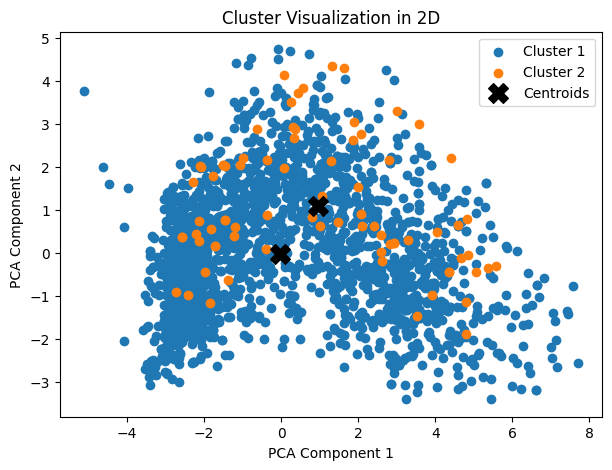

In [34]:
# Run K-Means for visualization with a chosen k
k = 2
kmeans = KMeansCustom(k)
kmeans.fit(data)

# Visualize the clusters
visualize_clusters(data, kmeans.labels, kmeans.centroids)

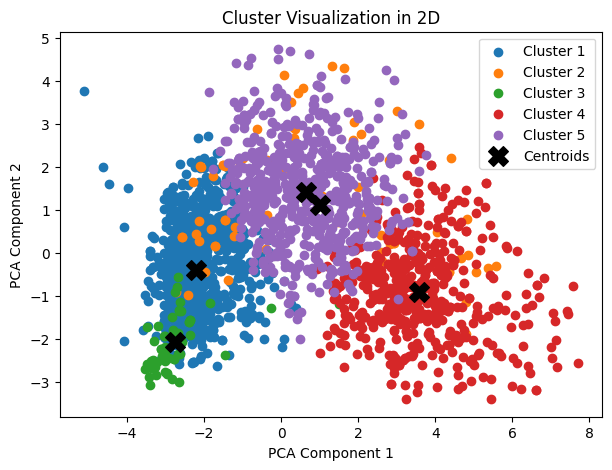

In [35]:
# Run K-Means for visualization with a chosen k
k = 5
kmeans = KMeansCustom(k)
kmeans.fit(data)

# Visualize the clusters
visualize_clusters(data, kmeans.labels, kmeans.centroids)

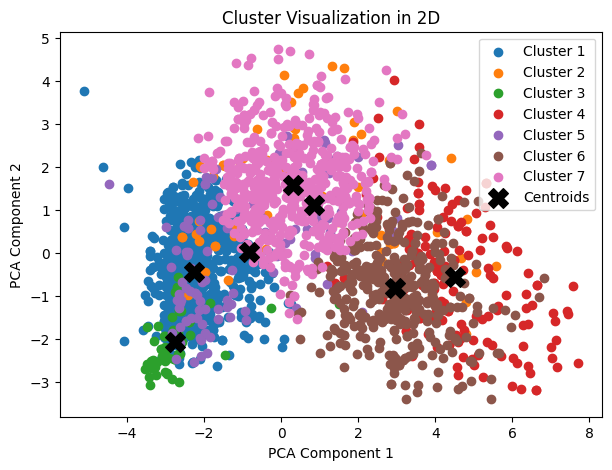

In [36]:
# Run K-Means for visualization with a chosen k
k = 7
kmeans = KMeansCustom(k)
kmeans.fit(data)

# Visualize the clusters
visualize_clusters(data, kmeans.labels, kmeans.centroids)

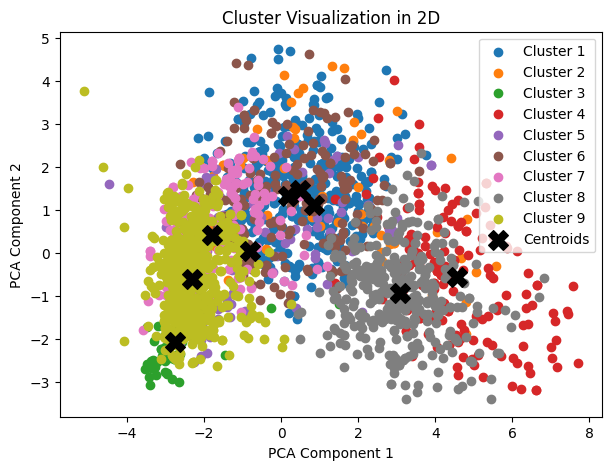

In [37]:
# Run K-Means for visualization with a chosen k
k = 9
kmeans = KMeansCustom(k)
kmeans.fit(data)

# Visualize the clusters
visualize_clusters(data, kmeans.labels, kmeans.centroids)